In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from tqdm import tqdm

import sys 
sys.path.append("..")

from src.models import ContextSpaceNet
from src.utils import ratemap_collage

#### Feedforward network

In [2]:
model = ContextSpaceNet(n_in = 3, n_out = 100)
model = model.load("../saved_models/FF_context_2")

In [3]:
# Evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x, y)

In [4]:
def spatial_correlation(a, b):
    a_flat = a.reshape(-1, a.shape[-1])
    b_flat = b.reshape(-1, b.shape[-1])

    sum_a = np.sum(a_flat, axis = 0)
    sum_b = np.sum(b_flat, axis = 0)

    mask = (sum_a > 0)*(sum_b > 0)
    
    a_flat = a_flat[...,mask]
    b_flat = b_flat[...,mask]

    corr = np.zeros(a_flat.shape[-1])
    for i in range(a_flat.shape[-1]):
        corr[i] = np.corrcoef(a_flat[...,i], b_flat[...,i])[1,0]
    return np.mean(corr)

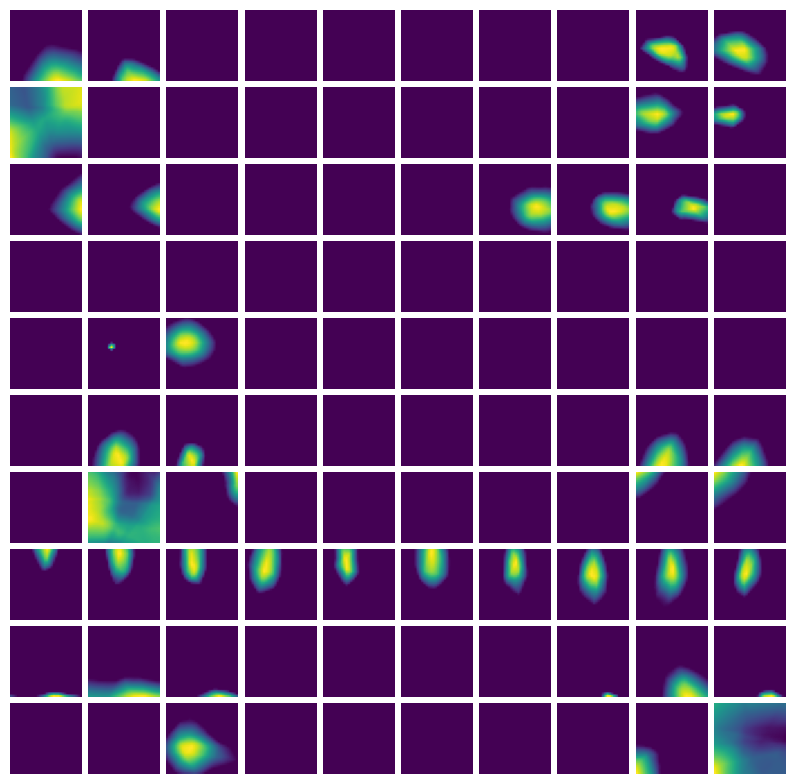

In [5]:
na = 10
nb = 10
fig, ax = plt.subplots(nb, na, figsize = (10, 10))

corrs = []

for i, c in enumerate(np.linspace(-5, 5, na)):
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), c*torch.ones(n**2)], axis=-1), dtype=torch.float32)
    corr, p = model(u)
    p = p.detach().numpy()
    for j in range(nb):
        ax[j,i].imshow(p[...,j].reshape(n,n))
        ax[j,i].axis("off")
plt.subplots_adjust(hspace=0, wspace=0.1)

In [6]:
nc = 16
corrs = np.zeros((nc, nc))
c = np.linspace(-5, 5, nc)

for i in range(nc):
    ua = torch.tensor(np.stack([xx.ravel(), yy.ravel(), c[i]*torch.ones(n**2)], axis=-1), dtype=torch.float32)
    corr, pa = model(ua)
    pa = pa.detach().numpy()
    for j in range(nc):
        ub = torch.tensor(np.stack([xx.ravel(), yy.ravel(), c[j]*torch.ones(n**2)], axis=-1), dtype=torch.float32)
        corr, pb = model(ub)
        pb = pb.detach().numpy()
        corrs[i,j] = spatial_correlation(pa, pb)

(16, 16)

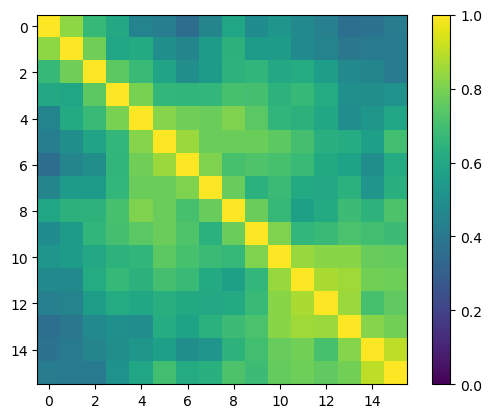

In [7]:
plt.imshow(corrs, vmin = 0)
plt.colorbar()
corrs.shape